In [1]:
#install.packages(c("tidyverse", "skimr", "janitor", "psych", "GGally", "car", "broom", "lmtest", "sandwich", 'gridExtra'))


## Leo Dataset

In [2]:
library(tidyverse)
#install.packages("GGally")
library(GGally)
library(broom)
#install.packages("lmtest")
library(lmtest)
#library(sandwich)
library(dplyr)
#install.packages("ggeffects")
library(ggeffects)
#install.packages("stargazer")
library(stargazer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Installing package into ‘/home/augusto/.local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/augusto/.local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Installing package into ‘/home/augusto/.local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘insight’, ‘datawiz

In [3]:
df <- read.csv(file = "https://infra.datos.gob.ar/catalog/sedronar/dataset/5/distribution/5.1/download/base-hogares-2022.csv", sep = ';')
head(df)

,ID_PER,WPER,CANT_MIEMBROS_HOGAR,CANT_PERSONAS0A17,CLIMA_EDUCATIVO,J_SEXO,J_EDAD,J_NIVEL_EDUCATIVO,SEXO_SEL,EDAD_SEL,⋯,ID_06B,ID_06C,ID_06D,ID_06E,ID_06F,ID_06G,ID_06H,ID_06I,ID_07,ID_08
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,336578,124,1,0,2,1,27,4,1,27,⋯,4,2,2,1,1,99,2,3,1,98
2,305909,781,1,0,3,1,33,6,1,33,⋯,2,2,1,3,2,3,2,4,2,NA
3,358892,34193,4,1,2,1,43,4,2,19,⋯,1,2,2,4,2,4,2,2,2,NA
4,342664,968,1,0,3,2,51,6,2,51,⋯,1,4,4,1,1,1,1,1,2,NA
5,394688,11509,2,0,3,2,59,5,1,31,⋯,2,1,1,2,2,4,2,2,2,NA
6,370155,13159,2,0,3,2,44,5,2,44,⋯,1,99,1,1,1,2,1,1,1,98


### Dimensiones

In [4]:
paste("Cantidad de filas:", nrow(df))
paste("Cantidad de columnas:", length(df))

[1] "Cantidad de filas: 12062"

[1] "Cantidad de columnas: 562"

## Transformaciones

### Recategorización

 Reordeno factores eliminando y usando los incompletos dado que inclueyen los niveles anteriores.

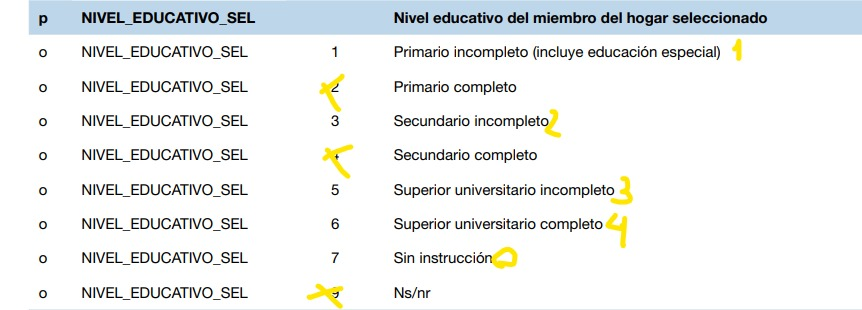

In [5]:
df <- df %>%
  # 1. Eliminar filas con valores 2, 4 y 9
  filter(!NIVEL_EDUCATIVO_SEL %in% c(2, 4, 9)) %>%

  # 2. Recodificar valores
  mutate(NIVEL_EDUCATIVO_SEL = case_when(
    NIVEL_EDUCATIVO_SEL == 7 ~ 0,
    NIVEL_EDUCATIVO_SEL == 1 ~ 1,
    NIVEL_EDUCATIVO_SEL == 3 ~ 2,
    NIVEL_EDUCATIVO_SEL == 5 ~ 3,
    NIVEL_EDUCATIVO_SEL == 6 ~ 4,
    TRUE ~ NA_real_  # por si aparece algún valor no esperado
  ))

#Sanity check
df %>% count(NIVEL_EDUCATIVO_SEL)



df <- df %>%
  # 2. Recodificar valores
  mutate(AL_01 = case_when(
    AL_01 == 2 ~ 0,
    AL_01 == 1 ~ 1,
    TRUE ~ 0  # por si aparece algún valor no esperado
  ))

#Sanity check
df %>% count(AL_01)

df <- df %>%
  # 2. Recodificar valores
  mutate(AL_04 = case_when(
    AL_04 == 2 ~ 0,
    AL_04 == 1 ~ 1,
    TRUE ~ 0  # por si aparece algún valor no esperado
  ))

#Sanity check
df %>% count(AL_04)

df <- df %>%
  # 2. Recodificar valores
  mutate(AL_16 = case_when(
    AL_16 == 1 ~ 0,
    AL_16 == 2 ~ 0,
    AL_16 == 3 ~ 0,
    AL_16 == 4 ~ 1,
    AL_16 == 5 ~ 1,
    AL_16 == 6 ~ 1,
    AL_16 == 7 ~ 0,
    AL_16 == 8 ~ 0,
    TRUE ~ 0  # por si aparece algún valor no esperado
  ))

#Sanity check
df %>% count(AL_16)


NIVEL_EDUCATIVO_SEL,n
<dbl>,<int>
0,63
1,518
2,2235
3,2050
4,2466


AL_01,n
<dbl>,<int>
0,1212
1,6120


AL_04,n
<dbl>,<int>
0,2454
1,4878


AL_16,n
<dbl>,<int>
0,6411
1,921


### Gráficos Alcohol

Warning message:
“Removed 17316 rows containing non-finite outside the scale range
(`stat_bin()`).”


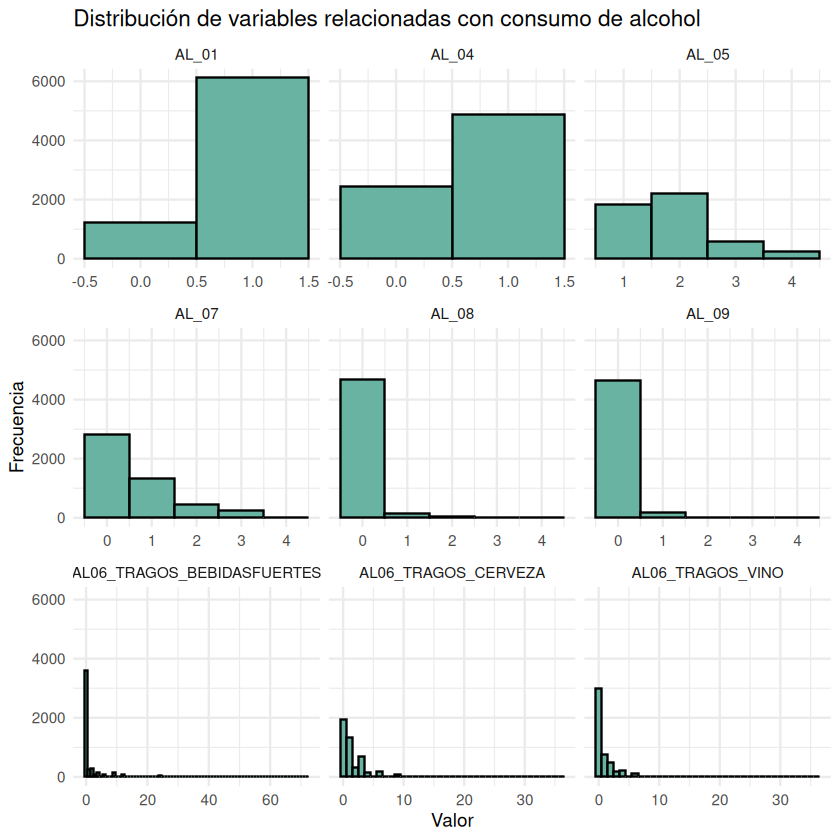

In [6]:
#Distribucion de variables relacionadas al alcohol antes de crear el indice.

library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)

# ---- FUNCIONES DE LIMPIEZA ----
# Convertir comas a punto y numeric
clean_numeric <- function(x) {
  if (is.character(x)) {
    x <- str_replace_all(x, ",", ".")
  }
  as.numeric(x)
}

# Reemplazar valores de "No contesta / No sabe / No recuerda" por NA
recode_missing <- function(x) {
  na_if(na_if(na_if(na_if(x, 98), 99), 998), 999)
}

# ---- VARIABLES RELACIONADAS CON ALCOHOL ----
alcohol_vars <- c(
  "AL_01", "AL_04", "AL_05",
  "AL_07", "AL_08", "AL_09",
  "AL06_TRAGOS_CERVEZA", "AL06_TRAGOS_VINO", "AL06_TRAGOS_BEBIDASFUERTES"
)

# ---- LIMPIEZA Y TRANSFORMACIÓN ----
df_alcohol <- df %>%
  select(all_of(alcohol_vars)) %>%
  mutate(across(everything(), clean_numeric)) %>%
  mutate(across(everything(), recode_missing))

# ---- PREPARAR PARA GRAFICOS ----
# Convertir de wide a long
df_long <- df_alcohol %>%
  pivot_longer(cols = everything(), names_to = "variable", values_to = "valor")

# ---- GRAFICO CON FACETAS ----
p_alcohol <- ggplot(df_long, aes(x = valor)) +
  geom_histogram(binwidth = 1, fill = "#69b3a2", color = "black") +
  facet_wrap(~variable, scales = "free_x") +
  labs(
    title = "Distribución de variables relacionadas con consumo de alcohol",
    x = "Valor",
    y = "Frecuencia"
  ) +
  theme_minimal()

# ---- MOSTRAR GRAFICO ----
p_alcohol

### Gráficos Eventos sociales

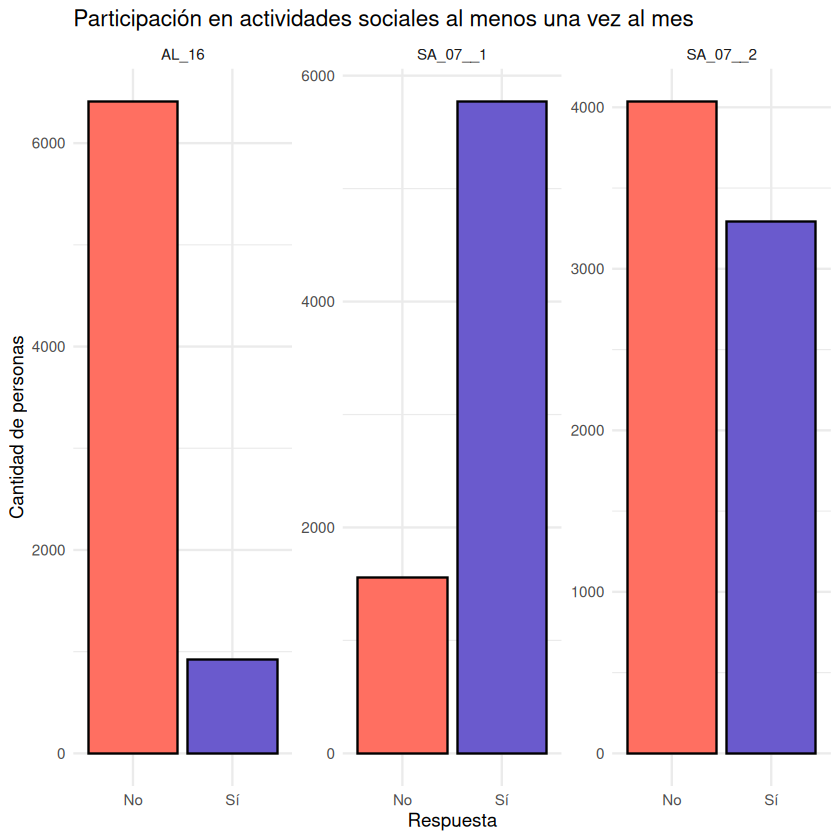

In [7]:

# Idem para eventos sociales


library(dplyr)
library(tidyr)
library(ggplot2)

# ---- VARIABLES DE EVENTOS SOCIALES ----
social_vars <- c("SA_07__1", "SA_07__2", "AL_16")

# ---- LIMPIEZA Y TRANSFORMACIÓN ----
df_social <- df %>%
  select(all_of(social_vars)) %>%
  mutate(across(everything(), ~na_if(.x, 99)))  # suponer 99 = No contesta

# ---- PREPARAR PARA GRAFICOS ----
# Convertir de wide a long
df_long_social <- df_social %>%
  pivot_longer(cols = everything(), names_to = "variable", values_to = "valor") %>%
  mutate(valor = factor(valor, levels = c(0,1), labels = c("No", "Sí")))

# ---- GRAFICO CON FACETAS ----
p_social <- ggplot(df_long_social, aes(x = valor, fill = valor)) +
  geom_bar(color = "black") +
  facet_wrap(~variable, scales = "free_y") +
  labs(
    title = "Participación en actividades sociales al menos una vez al mes",
    x = "Respuesta",
    y = "Cantidad de personas"
  ) +
  theme_minimal() +
  scale_fill_manual(values = c("No" = "#FF6F61", "Sí" = "#6A5ACD")) +
  theme(legend.position = "none")

# ---- MOSTRAR GRAFICO ----
p_social


### Creación de Índices

In [8]:
# ---- VARIABLES ----
social_vars <- c("SA_07__1", "SA_07__2", "AL_16")
alcohol_vars <- c(
  "AL_01", "AL_04", "AL_05",
  "AL_07", "AL_08", "AL_09",
  "AL06_TRAGOS_CERVEZA", "AL06_TRAGOS_VINO", "AL06_TRAGOS_BEBIDASFUERTES"
)

# ---- Filtrar solo columnas existentes en df ----
social_vars <- social_vars[social_vars %in% names(df)]
alcohol_vars <- alcohol_vars[alcohol_vars %in% names(df)]

# ---- Reemplazar códigos de no respuesta por NA y convertir a numérico ----
df[social_vars] <- lapply(df[social_vars], function(x) {
  x <- as.numeric(as.character(x))
  x[x %in% c(99,998,999)] <- 0
  return(x)
})

df[alcohol_vars] <- lapply(df[alcohol_vars], function(x) {
  x <- as.numeric(as.character(x))
  x[x %in% c(99,998,999)] <- 0
  return(x)
})

# ---- Crear índices ----
df$INDICE_SOCIALES <- rowSums(df[social_vars], na.rm = TRUE)
df$INDICE_ALCOHOL <- rowSums(df[alcohol_vars], na.rm = TRUE)

# ---- Revisar las primeras filas ----
head(df[, c("NIVEL_EDUCATIVO_SEL", "INDICE_SOCIALES", "INDICE_ALCOHOL")])

#Sanity check
df %>% count(INDICE_SOCIALES)
df %>% count(INDICE_ALCOHOL)


Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”
Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”
Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”


,NIVEL_EDUCATIVO_SEL,INDICE_SOCIALES,INDICE_ALCOHOL
,<dbl>,<dbl>,<dbl>
1,4,1,9
2,4,1,5
3,3,2,7
4,3,2,4
5,3,2,13
6,2,2,12


INDICE_SOCIALES,n
<dbl>,<int>
0,1287
1,2669
2,2808
3,568


INDICE_ALCOHOL,n
<dbl>,<int>
0,1212
1,1242
3,1105
4,1225
5,548
6,501
7,331
8,257
9,105


## Modelado

In [9]:
# Cargar datos
datos <- df

# Preparación de datos
datos_freq <- datos %>%
  # 1. Filtramos solo a quienes contestaron AL_05 (Los que consumen)
  filter(!is.na(INDICE_ALCOHOL)) %>%
  mutate(
    # 2. Variable Dependiente: Frecuencia (Tratada como numérica para ver tendencia)
    # Invertimos o mantenemos el orden según te convenga.
    # En el manual: 1 es "Poco" y 4 es "Mucho". Está perfecto así.
    INDICE_ALCOHOL = as.numeric(INDICE_ALCOHOL),

    # 3. Variable Independiente: Nivel Educativo (Usamos la original del manual)
    # 1=Prim Inc, 2=Prim Comp, 3=Sec Inc, 4=Sec Comp, 5=Sup Inc, 6=Sup Comp, 7=Sin Inst
    INDICE_SOCIALES = as.numeric(INDICE_SOCIALES),

    # 4. Confusor: Edad
    edad = EDAD_SEL
  )

# --- MODELO 1: "Lo que se ve a simple vista" (Naive) ---
# ¿A mayor educación, mayor frecuencia?
modelo_naive <- lm(INDICE_ALCOHOL ~ INDICE_SOCIALES, data = datos_freq)

# --- MODELO 2: "La realidad causal" (Controlado) ---
# ¿Qué pasa cuando le quitamos el efecto de la edad?
modelo_causal <- lm(INDICE_ALCOHOL ~ INDICE_SOCIALES + edad, data = datos_freq)


### Modelo ingenuo

In [10]:
# # Mostrar resultados
cat("Modelo ingenuo")
summary(modelo_naive)

Modelo ingenuo


Call:
lm(formula = INDICE_ALCOHOL ~ INDICE_SOCIALES, data = datos_freq)

Residuals:
   Min     1Q Median     3Q    Max 
-5.475 -2.878 -1.475  1.122 70.525 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      2.66887    0.11319   23.58   <2e-16 ***
INDICE_SOCIALES  1.40313    0.07029   19.96   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.167 on 7330 degrees of freedom
Multiple R-squared:  0.05156,	Adjusted R-squared:  0.05143 
F-statistic: 398.5 on 1 and 7330 DF,  p-value: < 2.2e-16


### Modelo Complejo

In [11]:
cat("Modelo complejo")
summary(modelo_causal)

Modelo complejo


Call:
lm(formula = INDICE_ALCOHOL ~ INDICE_SOCIALES + edad, data = datos_freq)

Residuals:
   Min     1Q Median     3Q    Max 
-6.418 -2.912 -1.148  1.209 69.626 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      4.843921   0.220116   22.01   <2e-16 ***
INDICE_SOCIALES  1.137909   0.073399   15.50   <2e-16 ***
edad            -0.043849   0.003818  -11.48   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.122 on 7329 degrees of freedom
Multiple R-squared:  0.06833,	Adjusted R-squared:  0.06807 
F-statistic: 268.7 on 2 and 7329 DF,  p-value: < 2.2e-16


### Gráficos

[1] "Registros válidos para el análisis: 7332"


Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”


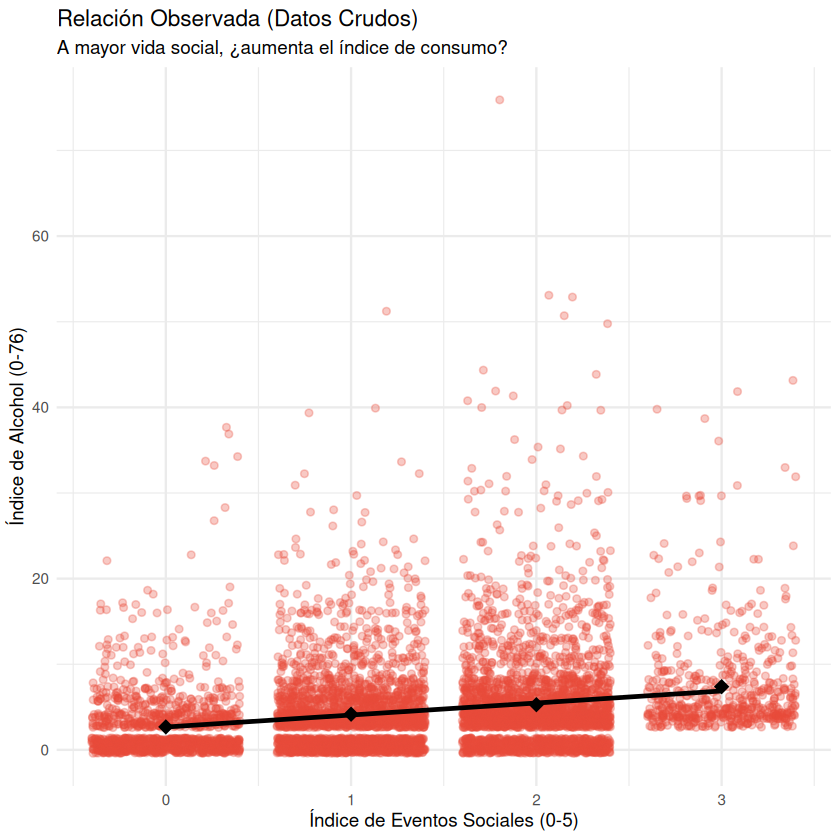

Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”


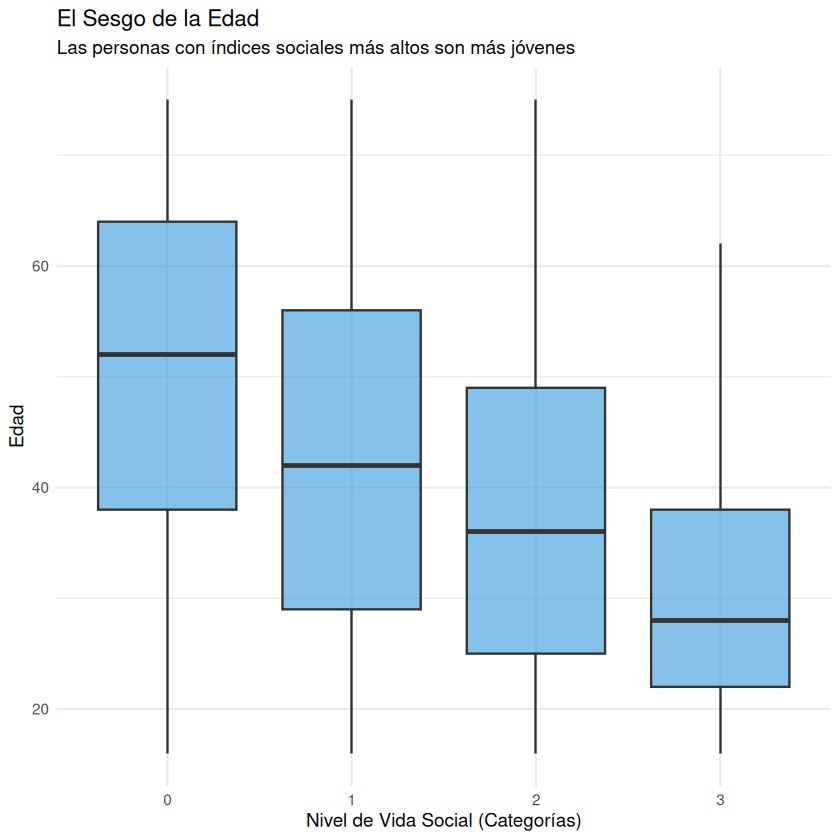

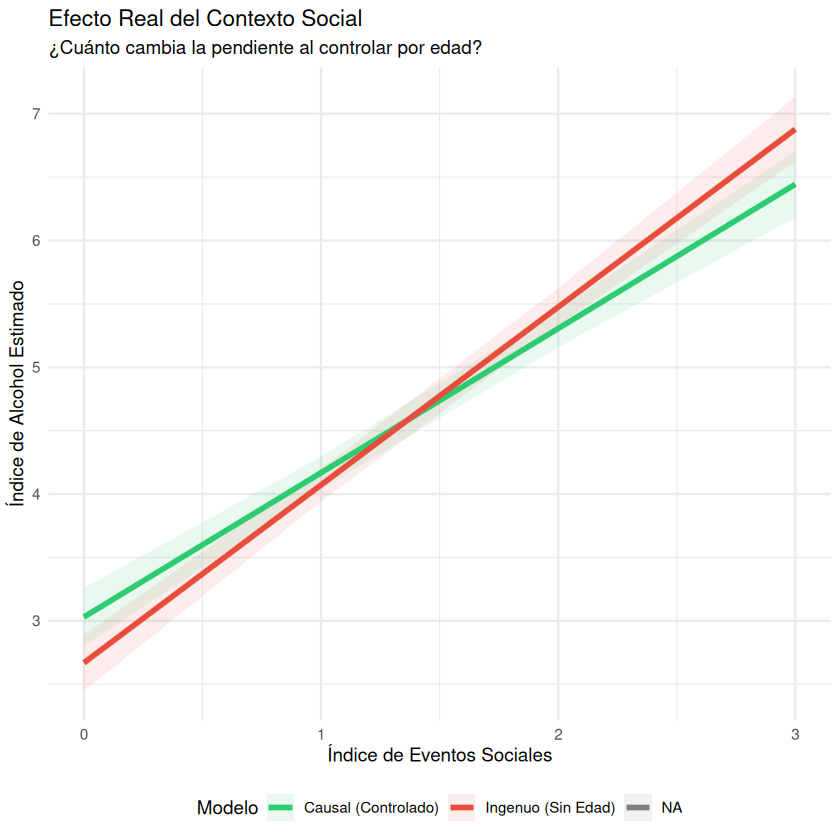

In [12]:
library(tidyverse)
library(ggeffects)

# -----------------------------------------------------------------------------
# 1. LIMPIEZA DE DATOS (El paso más importante)
# -----------------------------------------------------------------------------
# Asumimos que 'df' tiene tus variables creadas
datos_limpios <- df %>%
  select(INDICE_ALCOHOL, INDICE_SOCIALES, EDAD_SEL) %>%
  mutate(
    # Aseguramos que todo sea numérico
    INDICE_ALCOHOL = as.numeric(INDICE_ALCOHOL),
    INDICE_SOCIALES = as.numeric(INDICE_SOCIALES),
    edad = as.numeric(EDAD_SEL)
  ) %>%
  # ¡ESTA ES LA CLAVE! Elimina cualquier fila que tenga un dato faltante
  na.omit()

# Verificación rápida en consola (opcional)
print(paste("Registros válidos para el análisis:", nrow(datos_limpios)))

# -----------------------------------------------------------------------------
# 2. GRÁFICO 1: TENDENCIA OBSERVADA
# -----------------------------------------------------------------------------
grafico_naive <- ggplot(datos_limpios, aes(x = INDICE_SOCIALES, y = INDICE_ALCOHOL)) +
  # Puntos semitransparentes para ver la densidad de datos
  geom_point(alpha = 0.3, color = "#E74C3C", position = "jitter") +

  # Línea de tendencia suavizada
  geom_smooth(method = "lm", formula = y ~ x, se = TRUE, color = "black", fill = "#F1948A") +

  # Promedios (Puntos grandes negros) para ver la media por nivel social
  stat_summary(fun = mean, geom = "point", size = 4, color = "black", shape = 18) +

  labs(
    title = "Relación Observada (Datos Crudos)",
    subtitle = "A mayor vida social, ¿aumenta el índice de consumo?",
    x = "Índice de Eventos Sociales (0-5)",
    y = "Índice de Alcohol (0-76)"
  ) +
  theme_minimal()

ggsave("1_grafico_naive_final.png", plot = grafico_naive, width = 8, height = 5)


# -----------------------------------------------------------------------------
# 3. GRÁFICO 2: EL CONFUSOR (EDAD)
# -----------------------------------------------------------------------------
grafico_confusor <- ggplot(datos_limpios, aes(x = factor(INDICE_SOCIALES), y = edad)) +
  geom_boxplot(fill = "#3498DB", alpha = 0.6, outlier.shape = NA) +
  labs(
    title = "El Sesgo de la Edad",
    subtitle = "Las personas con índices sociales más altos son más jóvenes",
    x = "Nivel de Vida Social (Categorías)",
    y = "Edad"
  ) +
  theme_minimal()

ggsave("2_grafico_confusor_final.png", plot = grafico_confusor, width = 8, height = 5)


# -----------------------------------------------------------------------------
# 4. GRÁFICO 3: MODELO CAUSAL (El Veredicto)
# -----------------------------------------------------------------------------
# Corremos los modelos
m_naive <- lm(INDICE_ALCOHOL ~ INDICE_SOCIALES, data = datos_limpios)
m_causal <- lm(INDICE_ALCOHOL ~ INDICE_SOCIALES + edad, data = datos_limpios)

# Predicciones
# Usamos [all] para que calcule sobre los valores reales de tu índice social
pred_naive <- ggpredict(m_naive, terms = "INDICE_SOCIALES [all]") %>% mutate(Modelo = "Ingenuo (Sin Edad)")
pred_causal <- ggpredict(m_causal, terms = "INDICE_SOCIALES [all]") %>% mutate(Modelo = "Causal (Controlado)")

comparacion <- rbind(pred_naive, pred_causal)

grafico_final <- ggplot(comparacion, aes(x = x, y = predicted, color = Modelo)) +
  # Intervalos de confianza
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high, fill = Modelo), alpha = 0.1, color = NA) +
  # Líneas de tendencia
  geom_line(linewidth = 1.2) +

  scale_color_manual(values = c("#2ECC71", "#E74C3C")) +
  scale_fill_manual(values = c("#2ECC71", "#E74C3C")) +

  labs(
    title = "Efecto Real del Contexto Social",
    subtitle = "¿Cuánto cambia la pendiente al controlar por edad?",
    x = "Índice de Eventos Sociales",
    y = "Índice de Alcohol Estimado"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

ggsave("3_grafico_final_final.png", plot = grafico_final, width = 8, height = 5)

# Mostrar
print(grafico_naive)
print(grafico_confusor)
print(grafico_final)

In [32]:
summary(m_naive)
summary(m_causal)


Call:
lm(formula = INDICE_ALCOHOL ~ INDICE_SOCIALES, data = datos_limpios)

Residuals:
   Min     1Q Median     3Q    Max 
-5.475 -2.878 -1.475  1.122 70.525 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      2.66887    0.11319   23.58   <2e-16 ***
INDICE_SOCIALES  1.40313    0.07029   19.96   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.167 on 7330 degrees of freedom
Multiple R-squared:  0.05156,	Adjusted R-squared:  0.05143 
F-statistic: 398.5 on 1 and 7330 DF,  p-value: < 2.2e-16



Call:
lm(formula = INDICE_ALCOHOL ~ INDICE_SOCIALES + edad, data = datos_limpios)

Residuals:
   Min     1Q Median     3Q    Max 
-6.418 -2.912 -1.148  1.209 69.626 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      4.843921   0.220116   22.01   <2e-16 ***
INDICE_SOCIALES  1.137909   0.073399   15.50   <2e-16 ***
edad            -0.043849   0.003818  -11.48   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.122 on 7329 degrees of freedom
Multiple R-squared:  0.06833,	Adjusted R-squared:  0.06807 
F-statistic: 268.7 on 2 and 7329 DF,  p-value: < 2.2e-16


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


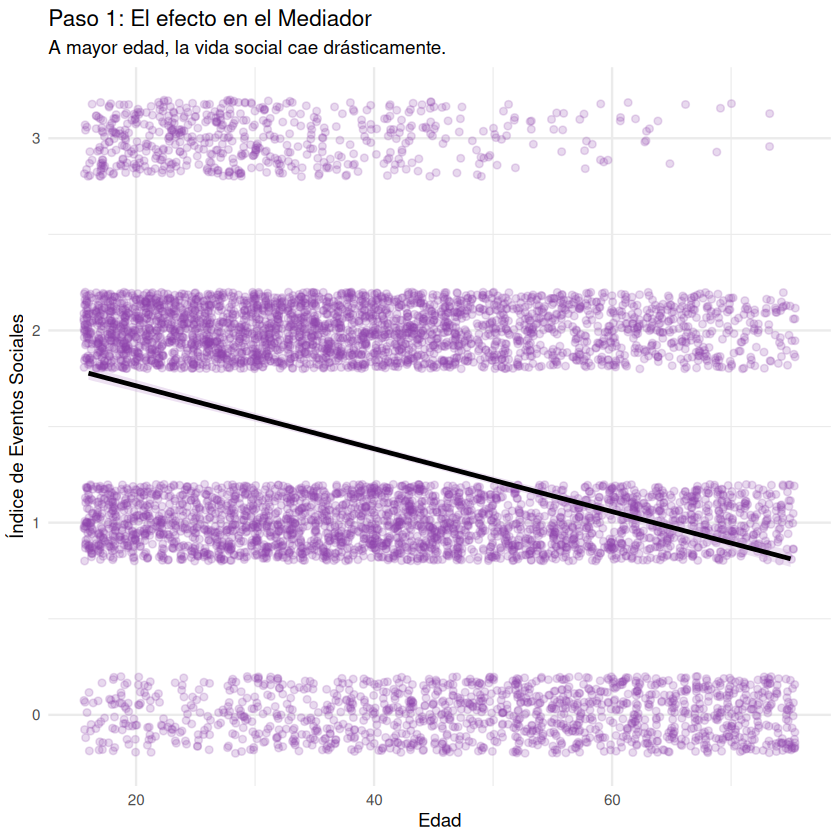

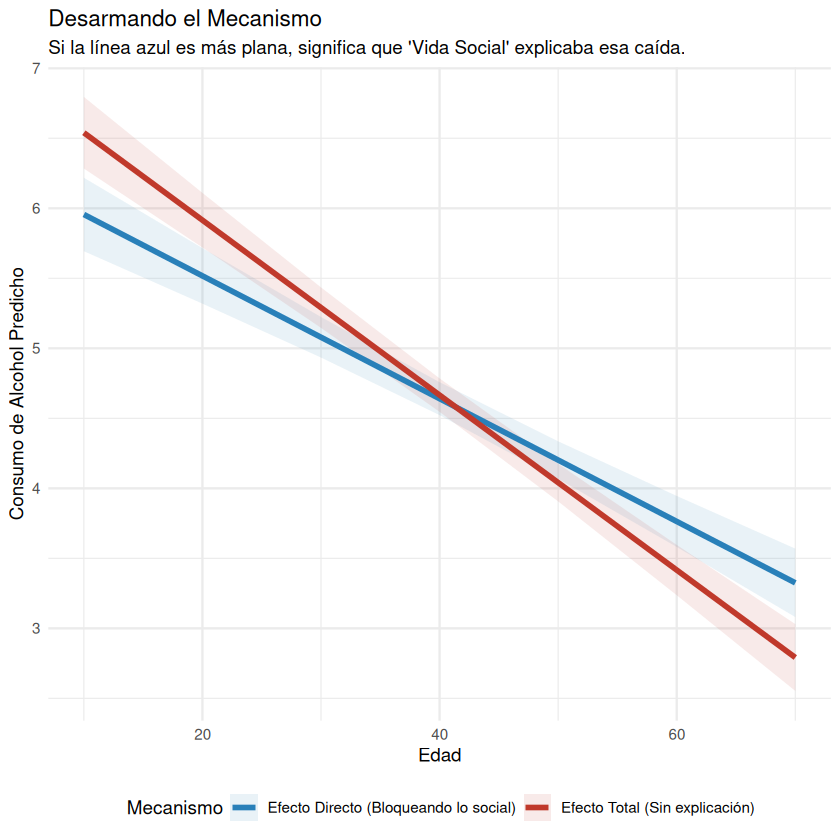

In [17]:
# =============================================================================
# DAG 2: LA CADENA (Mediación)
# Historia: "¿Por qué la edad baja el consumo? ¿Es biológico o es social?"
# =============================================================================

# 1. GRÁFICO DEL MEDIADOR: La edad "mata" la vida social
grafico_mediador <- ggplot(datos_limpios, aes(x = edad, y = INDICE_SOCIALES)) +
  geom_jitter(alpha = 0.2, color = "#8E44AD", height = 0.2) + # Puntos dispersos
  geom_smooth(method = "lm", color = "black", fill = "#D2B4DE") +
  labs(
    title = "Paso 1: El efecto en el Mediador",
    subtitle = "A mayor edad, la vida social cae drásticamente.",
    x = "Edad",
    y = "Índice de Eventos Sociales"
  ) +
  theme_minimal()

ggsave("4_chain_mediador.png", plot = grafico_mediador, width = 8, height = 5)

# 2. MODELOS: EFECTO TOTAL vs DIRECTO
# Modelo Total: Edad -> Alcohol (La "Caja Negra")
m_total <- lm(INDICE_ALCOHOL ~ edad, data = datos_limpios)

# Modelo Directo: Edad -> Alcohol (Controlando por Social)
# Aquí le decimos: "Compara gente de distinta edad PERO con la misma vida social"
m_directo <- lm(INDICE_ALCOHOL ~ edad + INDICE_SOCIALES, data = datos_limpios)

# 3. GRÁFICO COMPARATIVO (El Veredicto)
# Extraemos el efecto de la edad en ambos escenarios
pred_total <- ggpredict(m_total, terms = "edad") %>% mutate(Mecanismo = "Efecto Total (Sin explicación)")
pred_directo <- ggpredict(m_directo, terms = "edad") %>% mutate(Mecanismo = "Efecto Directo (Bloqueando lo social)")

comparacion_chain <- rbind(pred_total, pred_directo)

grafico_chain_final <- ggplot(comparacion_chain, aes(x = x, y = predicted, color = Mecanismo)) +
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high, fill = Mecanismo), alpha = 0.1, color = NA) +
  geom_line(linewidth = 1.2) +
  scale_color_manual(values = c("#2980B9", "#C0392B")) + # Azul y Rojo
  scale_fill_manual(values = c("#2980B9", "#C0392B")) +
  labs(
    title = "Desarmando el Mecanismo",
    subtitle = "Si la línea azul es más plana, significa que 'Vida Social' explicaba esa caída.",
    x = "Edad",
    y = "Consumo de Alcohol Predicho"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

ggsave("5_chain_resultado.png", plot = grafico_chain_final, width = 8, height = 5)

print(grafico_mediador)
print(grafico_chain_final)

In [34]:
summary(m_total)
summary(m_directo)


Call:
lm(formula = INDICE_ALCOHOL ~ edad, data = datos_limpios)

Residuals:
   Min     1Q Median     3Q    Max 
-6.165 -3.040 -1.102  1.334 69.898 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.164415   0.164005   43.68   <2e-16 ***
edad        -0.062471   0.003683  -16.96   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.205 on 7330 degrees of freedom
Multiple R-squared:  0.03777,	Adjusted R-squared:  0.03764 
F-statistic: 287.8 on 1 and 7330 DF,  p-value: < 2.2e-16



Call:
lm(formula = INDICE_ALCOHOL ~ edad + INDICE_SOCIALES, data = datos_limpios)

Residuals:
   Min     1Q Median     3Q    Max 
-6.418 -2.912 -1.148  1.209 69.626 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      4.843921   0.220116   22.01   <2e-16 ***
edad            -0.043849   0.003818  -11.48   <2e-16 ***
INDICE_SOCIALES  1.137909   0.073399   15.50   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.122 on 7329 degrees of freedom
Multiple R-squared:  0.06833,	Adjusted R-squared:  0.06807 
F-statistic: 268.7 on 2 and 7329 DF,  p-value: < 2.2e-16


## DAG 2: LA CADENA

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


[1] "--- GRÁFICO DEL MEDIADOR ---"


`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


[1] "--- GRÁFICO FINAL ---"


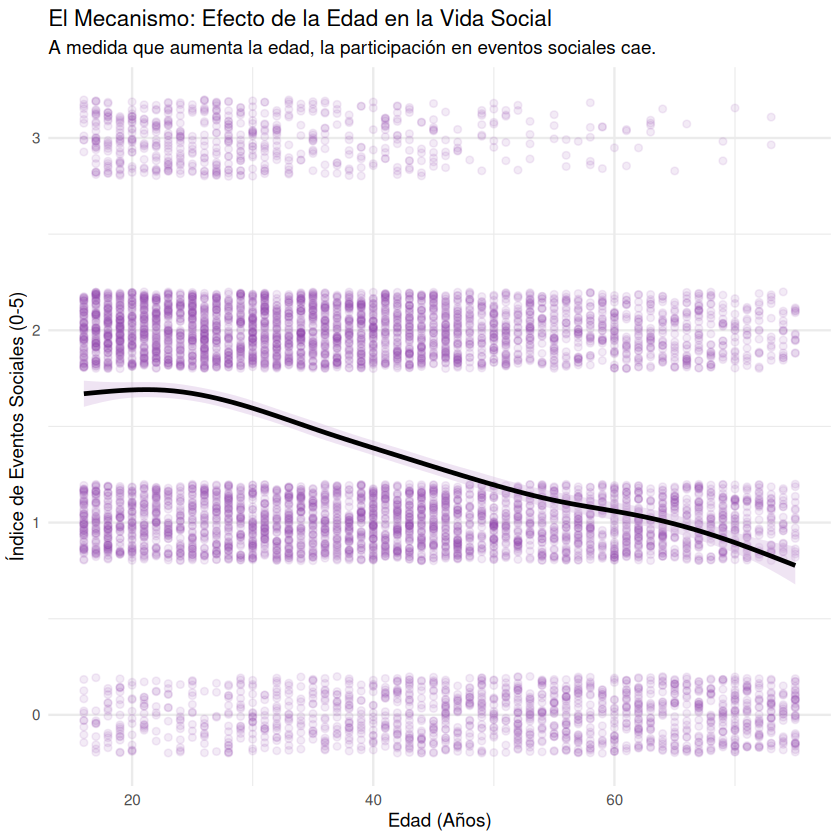

[1] "Porcentaje del efecto explicado por la vida social: 29.8 %"


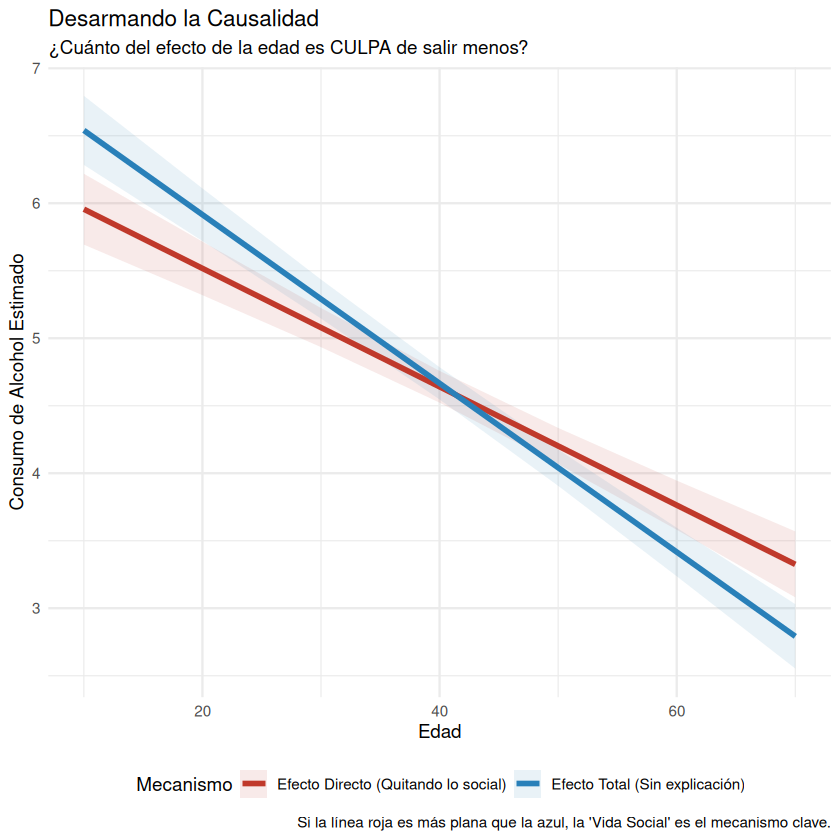

In [18]:
# =============================================================================
# DAG 2: LA CADENA (Mediación)
# Hipótesis: Edad -> Vida Social -> Alcohol
# Pregunta: "¿La edad baja el consumo porque cambia tu vida social?"
# =============================================================================

library(tidyverse)
library(ggeffects)

# Aseguramos que usamos los datos limpios (sin nulos) del paso anterior
# Si no corriste la limpieza del paso anterior, asegúrate de tener 'datos_limpios'

# -----------------------------------------------------------------------------
# 1. GRÁFICO A: EL ESLABÓN PERDIDO (Edad -> Vida Social)
# -----------------------------------------------------------------------------
# Primero demostramos que la edad efectivamente "mata" la vida social.
# Sin este paso, no hay cadena posible.

grafico_mediador <- ggplot(datos_limpios, aes(x = edad, y = INDICE_SOCIALES)) +
  # Puntos dispersos para ver la densidad
  geom_jitter(alpha = 0.1, color = "#8E44AD", height = 0.2, width = 0) + 
  
  # Línea de tendencia (Suavizada)
  geom_smooth(method = "gam", color = "black", fill = "#D7BDE2") +
  
  labs(
    title = "El Mecanismo: Efecto de la Edad en la Vida Social",
    subtitle = "A medida que aumenta la edad, la participación en eventos sociales cae.",
    x = "Edad (Años)",
    y = "Índice de Eventos Sociales (0-5)"
  ) +
  theme_minimal()

ggsave("4_chain_mecanismo.png", plot = grafico_mediador, width = 8, height = 5)


# -----------------------------------------------------------------------------
# 2. LOS MODELOS DE REGRESIÓN
# -----------------------------------------------------------------------------

# Modelo 1: Efecto TOTAL (La "Caja Negra")
# Ignoramos la vida social. Solo vemos cuánto baja el alcohol por cada año de edad.
m_total <- lm(INDICE_ALCOHOL ~ edad, data = datos_limpios)

# Modelo 2: Efecto DIRECTO (Bloqueando el Mediador)
# Controlamos por INDICE_SOCIALES. 
# Estamos comparando personas de distinta edad pero con la MISMA vida social.
m_directo <- lm(INDICE_ALCOHOL ~ edad + INDICE_SOCIALES, data = datos_limpios)


# -----------------------------------------------------------------------------
# 3. GRÁFICO B: EL VEREDICTO (Comparación de Pendientes)
# -----------------------------------------------------------------------------

# Predicciones para visualizar las pendientes
pred_total <- ggpredict(m_total, terms = "edad") %>% 
  mutate(Mecanismo = "Efecto Total (Sin explicación)")

pred_directo <- ggpredict(m_directo, terms = "edad") %>% 
  mutate(Mecanismo = "Efecto Directo (Quitando lo social)")

# Unimos los datos para graficar
comparacion_chain <- rbind(pred_total, pred_directo)

grafico_chain_final <- ggplot(comparacion_chain, aes(x = x, y = predicted, color = Mecanismo)) +
  # Intervalos de confianza (sombra)
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high, fill = Mecanismo), alpha = 0.1, color = NA) +
  
  # Líneas de tendencia
  geom_line(linewidth = 1.2) +
  
  # Colores: Azul para el total, Rojo para el directo
  scale_color_manual(values = c("#C0392B", "#2980B9")) + 
  scale_fill_manual(values = c("#C0392B", "#2980B9")) +
  
  labs(
    title = "Desarmando la Causalidad",
    subtitle = "¿Cuánto del efecto de la edad es CULPA de salir menos?",
    caption = "Si la línea roja es más plana que la azul, la 'Vida Social' es el mecanismo clave.",
    x = "Edad",
    y = "Consumo de Alcohol Estimado"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

ggsave("5_chain_conclusion.png", plot = grafico_chain_final, width = 8, height = 5)

# -----------------------------------------------------------------------------
# 4. SALIDA EN CONSOLA (Para tu análisis)
# -----------------------------------------------------------------------------
print("--- GRÁFICO DEL MEDIADOR ---")
print(grafico_mediador)

print("--- GRÁFICO FINAL ---")
print(grafico_chain_final)

# Cálculo rápido del porcentaje mediado (Opcional pero útil para el video)
coef_total <- coef(m_total)["edad"]
coef_directo <- coef(m_directo)["edad"]
porcentaje_mediado <- (coef_total - coef_directo) / coef_total * 100

print(paste("Porcentaje del efecto explicado por la vida social:", round(porcentaje_mediado, 1), "%"))

## DAG 3: EL FORK

Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”


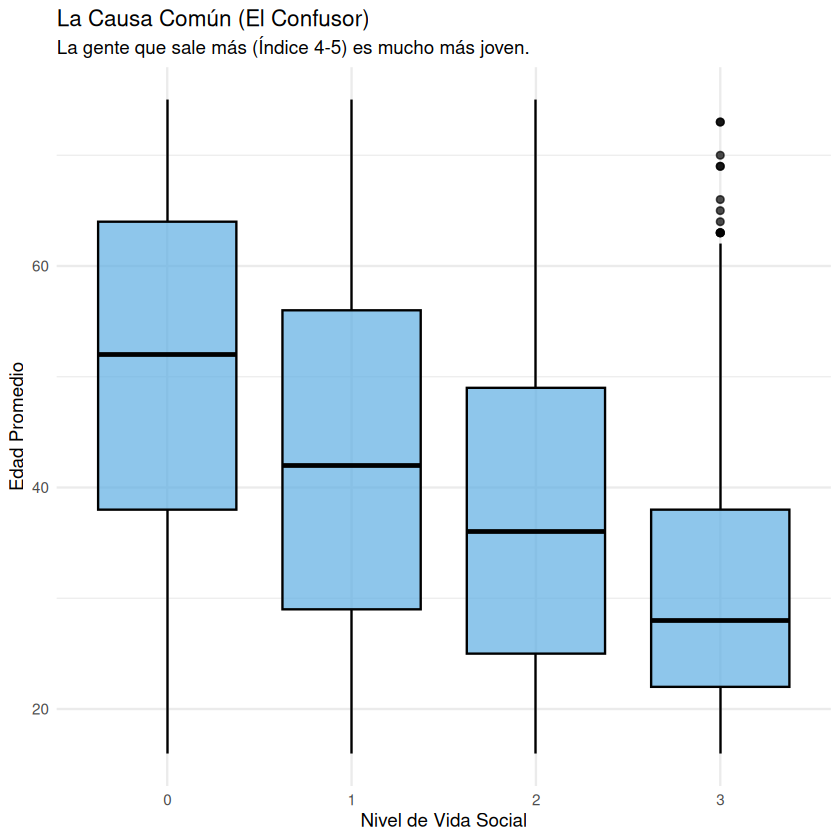

[1] "El modelo Naive sobreestimaba el efecto en un 23.3 % debido a la edad."


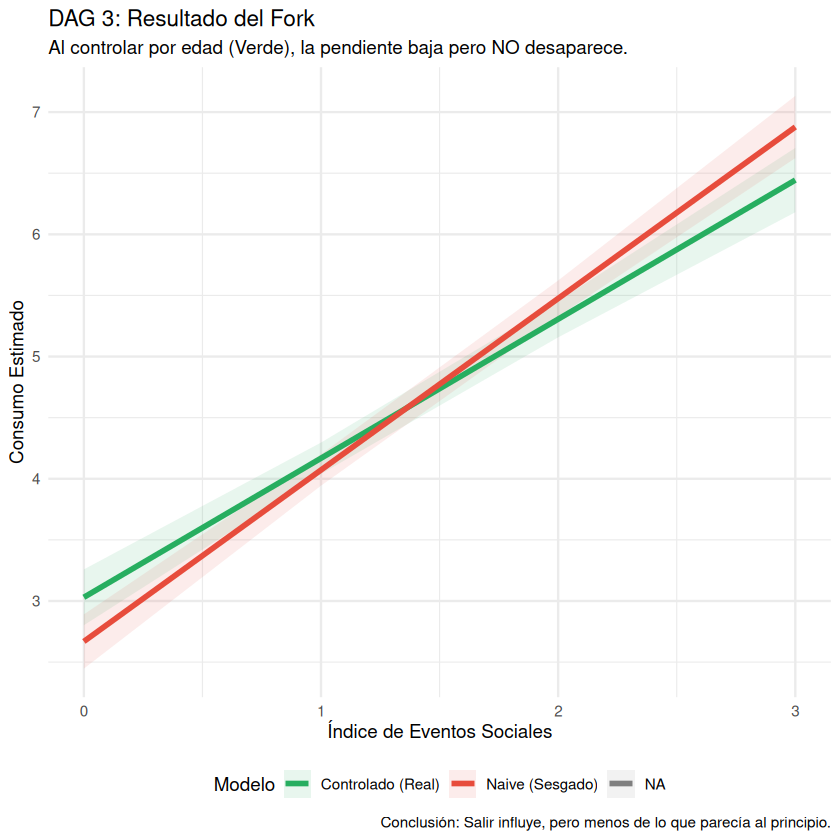

In [20]:
# =============================================================================
# DAG 3: EL FORK (Sesgo de Confusión)
# Hipótesis: La relación "Social -> Alcohol" está inflada por la Edad.
# Estructura: Vida Social <- Edad -> Alcohol
# =============================================================================

# 1. VISUALIZAR EL CONFUSOR (La Edad causa ambas cosas)
# Ya sabemos que Edad -> Alcohol (visto en DAG 2)
# Falta mostrar claro que Edad -> Vida Social (que también vimos, pero aquí es la fuente del sesgo)

# Este gráfico confirma que tenemos una "Causa Común"
grafico_fork_causa_comun <- ggplot(datos_limpios, aes(x = as.factor(INDICE_SOCIALES), y = edad)) +
  geom_boxplot(fill = "#5DADE2", color = "black", alpha = 0.7) +
  labs(
    title = "La Causa Común (El Confusor)",
    subtitle = "La gente que sale más (Índice 4-5) es mucho más joven.",
    x = "Nivel de Vida Social",
    y = "Edad Promedio"
  ) +
  theme_minimal()

ggsave("6_fork_confusor.png", plot = grafico_fork_causa_comun, width = 8, height = 5)

# 2. COMPARACIÓN FINAL (Desenmascarando el Sesgo)
# Modelo Naive (El que cree que salir causa todo el alcohol)
m_naive <- lm(INDICE_ALCOHOL ~ INDICE_SOCIALES, data = datos_limpios)

# Modelo Controlado (El que bloquea el camino de la edad)
m_fork <- lm(INDICE_ALCOHOL ~ INDICE_SOCIALES + edad, data = datos_limpios)

# Predicciones
pred_naive <- ggpredict(m_naive, terms = "INDICE_SOCIALES") %>% mutate(Modelo = "Naive (Sesgado)")
pred_fork <- ggpredict(m_fork, terms = "INDICE_SOCIALES") %>% mutate(Modelo = "Controlado (Real)")

comparacion_fork <- rbind(pred_naive, pred_fork)

grafico_fork_final <- ggplot(comparacion_fork, aes(x = x, y = predicted, color = Modelo)) +
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high, fill = Modelo), alpha = 0.1, color = NA) +
  geom_line(linewidth = 1.2) +
  scale_color_manual(values = c("#27AE60", "#E74C3C")) + # Verde (Bien), Rojo (Mal)
  scale_fill_manual(values = c("#27AE60", "#E74C3C")) +
  labs(
    title = "DAG 3: Resultado del Fork",
    subtitle = "Al controlar por edad (Verde), la pendiente baja pero NO desaparece.",
    caption = "Conclusión: Salir influye, pero menos de lo que parecía al principio.",
    x = "Índice de Eventos Sociales",
    y = "Consumo Estimado"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

ggsave("7_fork_conclusion.png", plot = grafico_fork_final, width = 8, height = 5)

print(grafico_fork_causa_comun)
print(grafico_fork_final)

# Cálculo de cuánto estaba inflado el efecto
coef_naive <- coef(m_naive)["INDICE_SOCIALES"]
coef_fork <- coef(m_fork)["INDICE_SOCIALES"]
sesgo_porcentaje <- (coef_naive - coef_fork) / coef_fork * 100

print(paste("El modelo Naive sobreestimaba el efecto en un", round(sesgo_porcentaje, 1), "% debido a la edad."))

In [37]:
coef_naive <- coef(m_naive)["INDICE_SOCIALES"]
coef_fork <- coef(m_fork)["INDICE_SOCIALES"]
(coef_naive - coef_fork) / coef_fork * 100

INDICE_SOCIALES 
       23.30739

In [23]:
datos_limpios <- df %>%
  # Agregamos J_SEXO a la lista de selección
  select(INDICE_ALCOHOL, INDICE_SOCIALES, EDAD_SEL, J_SEXO) %>%
  mutate(
    INDICE_ALCOHOL = as.numeric(INDICE_ALCOHOL),
    INDICE_SOCIALES = as.numeric(INDICE_SOCIALES),
    edad = as.numeric(EDAD_SEL),
    # Aseguramos que J_SEXO se lea (a veces viene como caracter o factor)
    J_SEXO = as.factor(J_SEXO) 
  ) %>%
  na.omit()

print("Datos actualizados correctamente con la variable Sexo.")

[1] "Datos actualizados correctamente con la variable Sexo."


## DAG 4 : EL COLISIONADOR

[1] "Conteo por Sexo:"

   1    2 
3226 4106 


Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_line()`).”


[1] "--- RESULTADOS COLISIONADOR ---"


Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_line()`).”


[1] "Diferencia entre Sexos (Modelo Real):"
  SEXO_SEL2 
-0.05200334 
[1] "Diferencia entre Sexos (Modelo Sesgado):"
 SEXO_SEL2 
0.03780739 


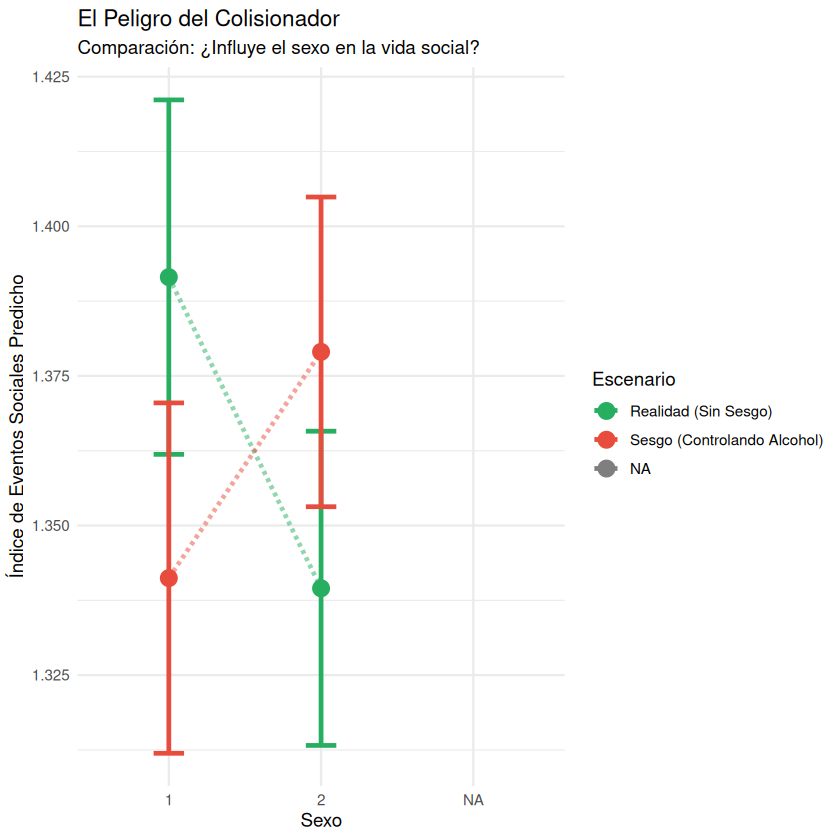

In [25]:
# =============================================================================
# DAG 4 : EL COLISIONADOR
# =============================================================================

# 1. ACTUALIZAR DATOS LIMPIOS
# Agregamos SEXO_SEL en lugar de J_SEXO
datos_limpios <- df %>%
  select(INDICE_ALCOHOL, INDICE_SOCIALES, EDAD_SEL, SEXO_SEL) %>%
  mutate(
    INDICE_ALCOHOL = as.numeric(INDICE_ALCOHOL),
    INDICE_SOCIALES = as.numeric(INDICE_SOCIALES),
    edad = as.numeric(EDAD_SEL),
    # Aseguramos que sea factor (categoría)
    SEXO_SEL = as.factor(SEXO_SEL) 
  ) %>%
  na.omit()

# Verificamos que haya datos de ambos sexos (Deberías ver números > 0 en ambos)
print("Conteo por Sexo:")
print(table(datos_limpios$SEXO_SEL))

# 2. CREAR ESCENARIO SESGADO
datos_collider <- datos_limpios %>%
  mutate(
    GRUPO = ifelse(INDICE_ALCOHOL > 0, "Muestra Sesgada (Solo Bebedores)", "Población Total")
  )

# 3. MODELOS
# Modelo Real (Sin controlar por alcohol)
m_real <- lm(INDICE_SOCIALES ~ SEXO_SEL, data = datos_limpios)

# Modelo Sesgado (Controlando por alcohol -> El error)
m_sesgado <- lm(INDICE_SOCIALES ~ SEXO_SEL + INDICE_ALCOHOL, data = datos_limpios)

# 4. GRAFICAR (Corregido 'size' por 'linewidth')
pred_real <- ggpredict(m_real, terms = "SEXO_SEL") %>% mutate(Escenario = "Realidad (Sin Sesgo)")
pred_sesgado <- ggpredict(m_sesgado, terms = "SEXO_SEL") %>% mutate(Escenario = "Sesgo (Controlando Alcohol)")

comparacion_collider <- rbind(pred_real, pred_sesgado)

grafico_collider <- ggplot(comparacion_collider, aes(x = x, y = predicted, color = Escenario, group = Escenario)) +
  # Intervalos de confianza
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2, linewidth = 1) +
  geom_point(size = 4) +
  
  # Líneas conectores
  geom_line(linetype = "dashed", alpha = 0.5, linewidth = 1) +
  
  scale_color_manual(values = c("#27AE60", "#E74C3C")) +
  labs(
    title = "El Peligro del Colisionador",
    subtitle = "Comparación: ¿Influye el sexo en la vida social?",
    x = "Sexo",
    y = "Índice de Eventos Sociales Predicho"
  ) +
  theme_minimal()

ggsave("8_collider_final.png", plot = grafico_collider, width = 8, height = 5)

# 5. RESULTADOS
print("--- RESULTADOS COLISIONADOR ---")
print(grafico_collider)

# Verificamos los coeficientes numéricos
print("Diferencia entre Sexos (Modelo Real):")
print(coef(m_real)[2]) # Debería ser un número pequeño
print("Diferencia entre Sexos (Modelo Sesgado):")
print(coef(m_sesgado)[2]) # Debería cambiar

## Graficos de Grafos


Attaching package: ‘ggdag’


The following object is masked from ‘package:stats’:

    filter




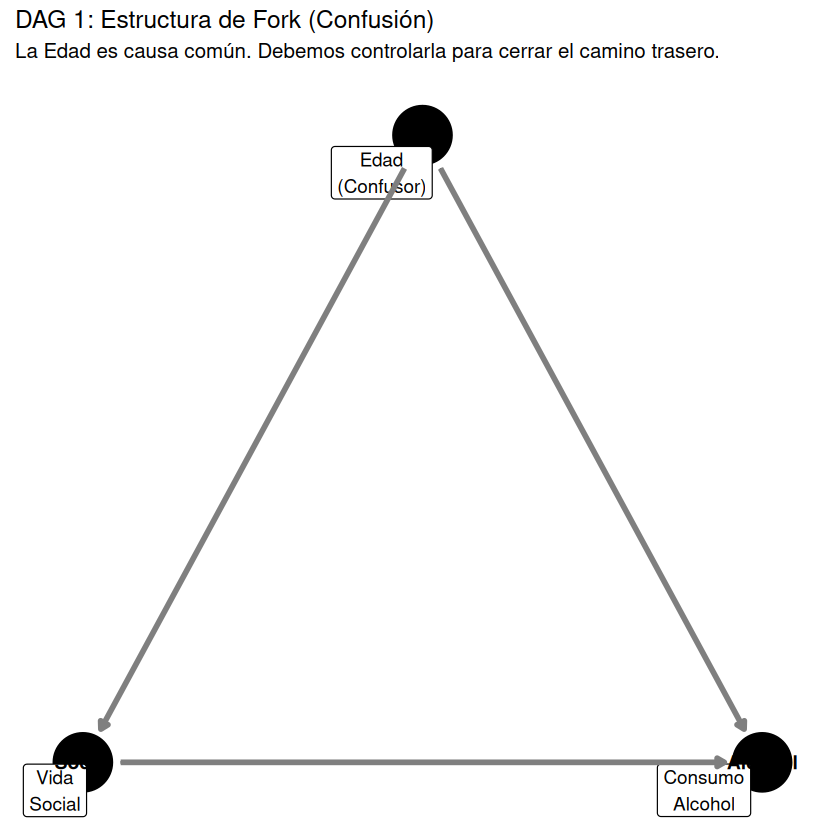

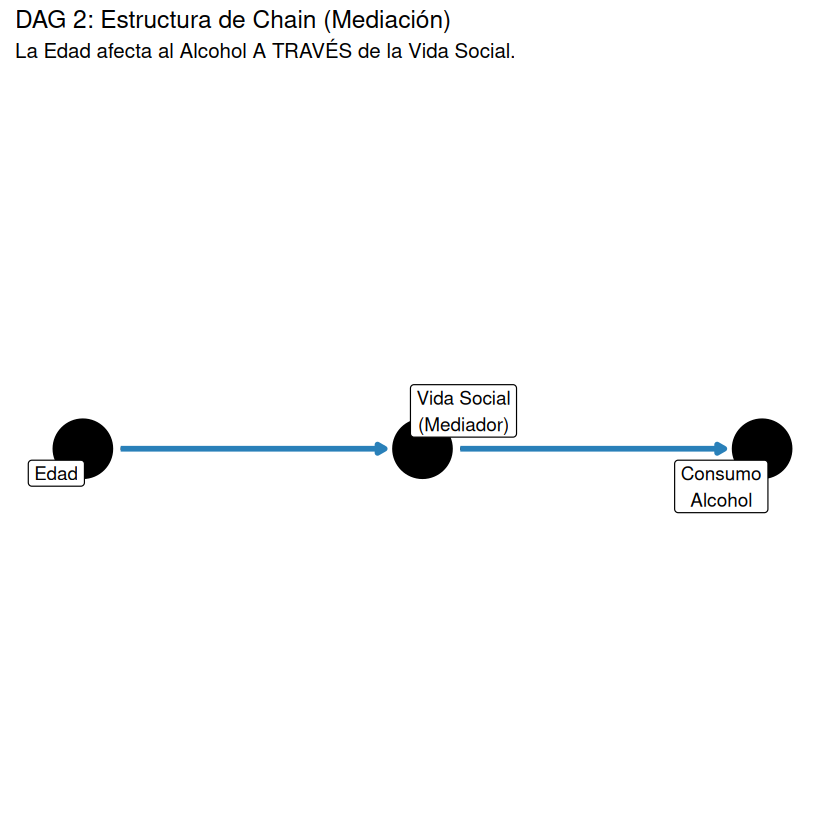

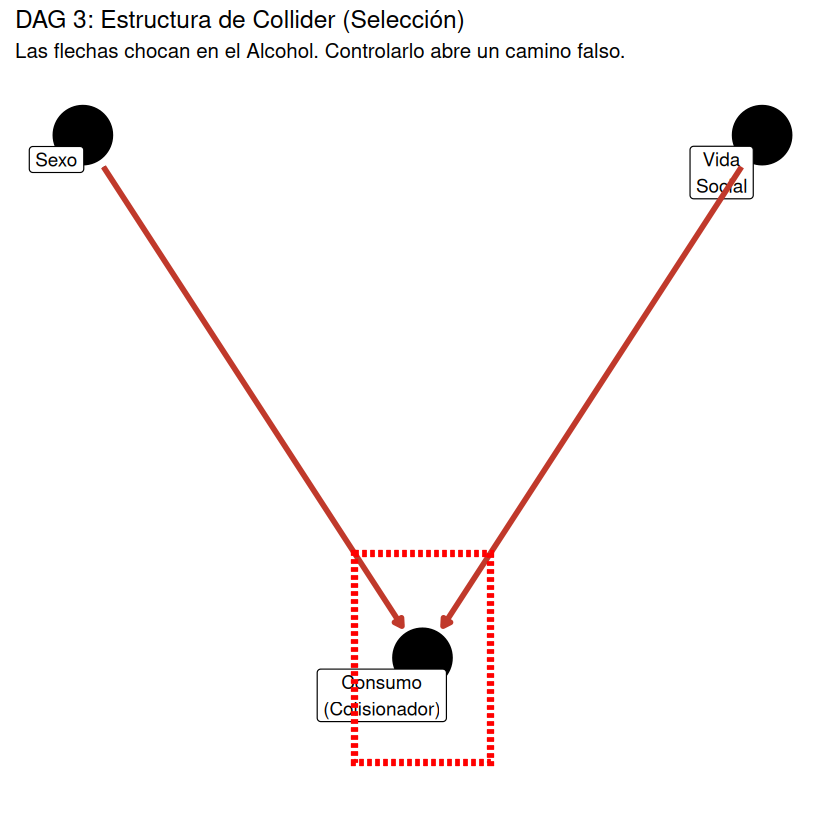

In [29]:
# =============================================================================
# VISUALIZACIÓN DE LOS 3 DAGs CONCEPTUALES
# =============================================================================
library(ggdag)
library(ggplot2)

# Configuramos un tema común limpio
theme_set(theme_dag())

# -----------------------------------------------------------------------------
# 1. DAG FORK (El Confusor)
# Estructura: La Edad causa tanto la Vida Social como el Consumo
# -----------------------------------------------------------------------------
dag_fork <- dagify(
  Social ~ Edad,      # La Edad influye en cuánto sales
  Alcohol ~ Edad,     # La Edad influye en cuánto tomas
  Alcohol ~ Social,   # La relación que queremos estudiar (cuestionada)
  exposure = "Social",
  outcome = "Alcohol",
  labels = c(
    "Alcohol" = "Consumo\nAlcohol", 
    "Social" = "Vida\nSocial", 
    "Edad" = "Edad\n(Confusor)"
  ),
  # Coordenadas manuales para que quede como un triángulo perfecto
  coords = list(x = c(Edad = 1, Social = 0, Alcohol = 2),
                y = c(Edad = 2, Social = 1, Alcohol = 1))
)

grafico_dag1 <- ggdag(dag_fork, text = FALSE, use_labels = "label") +
  geom_dag_edges(edge_color = "gray50", edge_width = 1.2) +
  geom_dag_text(color = "black", fontface = "bold") +
  labs(title = "DAG 1: Estructura de Fork (Confusión)",
       subtitle = "La Edad es causa común. Debemos controlarla para cerrar el camino trasero.")

# -----------------------------------------------------------------------------
# 2. DAG CHAIN (El Mecanismo)
# Estructura: Edad -> Vida Social -> Alcohol
# -----------------------------------------------------------------------------
dag_chain <- dagify(
  Social ~ Edad,      # Edad causa cambios en Vida Social
  Alcohol ~ Social,   # Vida Social causa cambios en Alcohol
  exposure = "Edad",
  outcome = "Alcohol",
  labels = c(
    "Alcohol" = "Consumo\nAlcohol", 
    "Social" = "Vida Social\n(Mediador)", 
    "Edad" = "Edad"
  ),
  # Coordenadas en línea recta o escalonada
  coords = list(x = c(Edad = 0, Social = 1, Alcohol = 2),
                y = c(Edad = 1, Social = 1, Alcohol = 1))
)

grafico_dag2 <- ggdag(dag_chain, text = FALSE, use_labels = "label") +
  geom_dag_edges(edge_color = "#2980B9", edge_width = 1.2) + # Azul para diferenciar
  labs(title = "DAG 2: Estructura de Chain (Mediación)",
       subtitle = "La Edad afecta al Alcohol A TRAVÉS de la Vida Social.")

# -----------------------------------------------------------------------------
# 3. DAG COLLIDER (La Trampa)
# Estructura: Sexo -> Alcohol <- Vida Social
# -----------------------------------------------------------------------------
dag_collider <- dagify(
  Alcohol ~ Sexo,     # El sexo puede influir en el consumo
  Alcohol ~ Social,   # La vida social influye en el consumo
  # Importante: No hay flecha entre Sexo y Social
  labels = c(
    "Alcohol" = "Consumo\n(Colisionador)", 
    "Social" = "Vida\nSocial", 
    "Sexo" = "Sexo"
  ),
  coords = list(x = c(Sexo = 0, Social = 2, Alcohol = 1),
                y = c(Sexo = 2, Social = 2, Alcohol = 1))
)

# En este gráfico resaltamos el nodo "Alcohol" para mostrar que lo estamos condicionando (caja)
grafico_dag3 <- ggdag(dag_collider, text = FALSE, use_labels = "label") +
  geom_dag_edges(edge_color = "#C0392B", edge_width = 1.2) + # Rojo de advertencia
  # Agregamos un recuadro alrededor del colisionador para indicar "Control/Filtro"
  geom_rect(aes(xmin = 0.8, xmax = 1.2, ymin = 0.8, ymax = 1.2), 
            fill = NA, color = "red", size = 1.5, linetype = "dashed") +
  labs(title = "DAG 3: Estructura de Collider (Selección)",
       subtitle = "Las flechas chocan en el Alcohol. Controlarlo abre un camino falso.")

# -----------------------------------------------------------------------------
# GUARDAR LOS GRÁFICOS
# -----------------------------------------------------------------------------
ggsave("DAG_1_Fork.png", plot = grafico_dag1, width = 7, height = 5)
ggsave("DAG_2_Chain.png", plot = grafico_dag2, width = 7, height = 5)
ggsave("DAG_3_Collider.png", plot = grafico_dag3, width = 7, height = 5)

# Mostrar en consola
print(grafico_dag1)
print(grafico_dag2)
print(grafico_dag3)

In [28]:
install.packages("ggdag")

Installing package into ‘/home/augusto/.local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘dagitty’


